# Data processing

In [18]:
import os
from pathlib import Path
import glob
import numpy as np

directory_path1 = Path('data/Experiment1')
directory_path2 = Path('data/Experiment2')
directory_path3 = Path('data/Experiment3')
directory_path4 = Path('data/Experiment4')
directory_path5 = Path('data/Experiment5')
directory_path6 = Path('data/Experiment6')

data = []
silhouette_results = []

def generate_data(content):
    X_temp = []
    num_beacons = int(content[0].strip())
    lines_beacons_data = content[1:num_beacons+1]
    for line in lines_beacons_data:
        splitted_data = line.strip().split()
        beacon_cluster = int(splitted_data[0])
        beacon_ray_index = int(splitted_data[1])
        beacon_x_relative = np.double(splitted_data[2])
        beacon_y_relative = np.double(splitted_data[3])
        X_temp.append((beacon_x_relative, beacon_y_relative, beacon_ray_index))
    if num_beacons < 3:
        for _ in range(3 - num_beacons):
            X_temp.append((0, 0, 0))
    splitted_data = content[num_beacons + 1].strip().split()
    global_robot_x = np.double(splitted_data[0])
    global_robot_y = np.double(splitted_data[1])
    silhouette_result = np.double(content[num_beacons + 2])
    Y_temp = [global_robot_x, global_robot_y]
    return X_temp, Y_temp, silhouette_result

def work_with_directory(root, remove_first_beacon=False, remove_second_beacon=False):
    X_temp = []
    Y_temp = []
    silhouette_result_temp = []
    for txt_file in glob.glob(os.path.join(root, '*.txt')):
        with open(txt_file, 'r') as file:
            content = file.readlines()
            X, Y, silhouette_result = generate_data(content)
            if remove_first_beacon:
                X[-1] = (0,0,0)
            if remove_second_beacon:
                X[-2] = (0,0,0)
            X_temp.append(X)
            Y_temp.append(Y)
            silhouette_result_temp.append(silhouette_result)
    if len(X_temp) > 0 and len(Y_temp) > 0:
        data.append((np.array(X_temp), np.array(Y_temp)))
        silhouette_results.append(silhouette_result_temp)

for root, _, __ in os.walk(directory_path1):
    work_with_directory(root)

for root, _, __ in os.walk(directory_path2):
    work_with_directory(root, remove_first_beacon=True)

for root, _, __ in os.walk(directory_path3):
    work_with_directory(root, remove_first_beacon=True, remove_second_beacon=True)

data

[(array([[[ 2.85116474e+00, -2.61599886e+00,  2.77000000e+02],
          [ 3.86857014e+00, -2.87758777e-01,  3.53000000e+02],
          [-1.07155346e+00,  4.96419207e-01,  6.78000000e+02]],
  
         [[ 2.67413076e+00, -1.89205537e+00,  2.92000000e+02],
          [ 3.17562000e+00,  6.03610715e-01,  3.84000000e+02],
          [-1.82468303e+00,  3.16889845e-01,  7.05000000e+02]],
  
         [[ 6.16119562e-01, -2.91566454e+00,  2.07000000e+02],
          [ 2.72169416e+00, -1.49459468e+00,  3.05000000e+02],
          [-1.04245316e+00,  1.81588499e+00,  6.04000000e+02]],
  
         [[-5.58027288e-01, -3.05832397e+00,  1.62000000e+02],
          [ 1.97626786e+00, -2.82746529e+00,  2.52000000e+02],
          [ 2.53016757e-01,  1.87681534e+00,  5.29000000e+02]],
  
         [[ 1.87104499e+00, -2.91443706e+00,  2.48000000e+02],
          [-1.96201822e+00,  3.31726817e-01,  7.05000000e+02],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
  
         [[ 1.32416517e+00, -2.9471

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.utils import plot_model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU.")
else:
    print("TensorFlow cannot find GPU. Check your GPU setup.")


ModuleNotFoundError: No module named 'tensorflow.core'

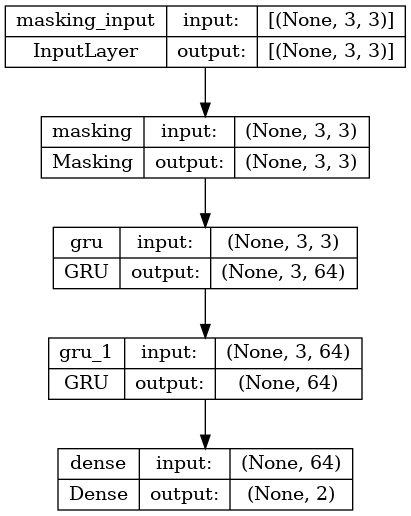

In [4]:
model = Sequential([
    Masking(mask_value=0., input_shape=(3, 3)),
    GRU(64, return_sequences=True),
    GRU(64),
    Dense(2)  # Output layer: predicting 2 coordinates
])

model.compile(optimizer='adam', loss='mse')

# Generate a plot of the model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


# Learning and Print results

In [5]:
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


current_full_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
checkpoints_path = Path(f'checkpoints/{current_full_time}')
if not checkpoints_path.exists():
    checkpoints_path.mkdir(parents=True, exist_ok=True)

last_time = None

test_losses = []
predictions = []
true_values = []
for one_step_data in data:
    X = one_step_data[0]
    Y = one_step_data[1]
    # print(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    model.fit(X_train, Y_train, epochs=300000, verbose=0)
    
    current_time = datetime.now().strftime("%H-%M-%S")
    last_time = current_time
    model_path = f'{checkpoints_path}/{current_time}.h5'
    model.save(model_path)
    
    loaded_model = load_model(model_path)
    Y_pred = loaded_model.predict(X_test)
    loss = loaded_model.evaluate(X_test, Y_test)
    test_losses.append(loss)
    predictions.append(Y_pred)
    true_values.append(Y_test)
    print("Test Loss:", loss)



/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 829ms/step - loss: 0.0370
Test Loss: 0.0370178297162056
1/1 [==============================] - 1s 663ms/step - loss: 0.0413
Test Loss: 0.041323572397232056
1/1 [==============================] - 1s 650ms/step - loss: 0.0184
Test Loss: 0.018387867137789726
1/1 [==============================] - 1s 699ms/step - loss: 0.0124
Test Loss: 0.012379777617752552
1/1 [==============================] - 1s 700ms/step - loss: 0.0396
Test Loss: 0.03958390653133392
1/1 [==============================] - 1s 660ms/step - loss: 0.0153
Test Loss: 0.015336954034864902
1/1 [==============================] - 1s 644ms/step - loss: 0.0104
Test Loss: 0.010379052720963955
1/1 [==============================] - 1s 656ms/step - loss: 0.0104
Test Loss: 0.010421138256788254
1/1 [==============================] - 1s 648ms/step - loss: 0.0411
Test Loss: 0.04110754281282425
1/1 [==============================] - 1s 893ms/step - loss: 0.0333
Test Loss: 0.033256128430366516
1/1 

In [7]:
import matplotlib.pyplot as plt
import imageio
import math

distances = []

def distance_between_two_points(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def create_gif_for_sample(true, pred, sample_idx, checkpoints_path):
    filenames = []
    num_points = len(true)
    
    # Determine fixed axis limits
    all_x = np.concatenate([true[:, 0], pred[:, 0]])
    all_y = np.concatenate([true[:, 1], pred[:, 1]])
    min_x, max_x = all_x.min(), all_x.max()
    min_y, max_y = all_y.min(), all_y.max()

    # Add some padding to the limits
    x_pad = (max_x - min_x) * 0.1
    y_pad = (max_y - min_y) * 0.1
    limits = (min_x - x_pad, max_x + x_pad, min_y - y_pad, max_y + y_pad)

    new_distances = []

    for point in range(num_points + 1):
        plt.figure(figsize=(10, 6))
        plt.plot(true[:point, 0], true[:point, 1], color='blue', label='True Values', marker='o')
        plt.plot(pred[:point, 0], pred[:point, 1], color='red', label='Predictions', marker='o')
        
        # Highlight the last point in a different color
        if point > 0:
            plt.scatter(true[point-1, 0], true[point-1, 1], color='green', s=200, edgecolors='black')  # True values
            plt.scatter(pred[point-1, 0], pred[point-1, 1], color='yellow', s=200, edgecolors='black')  # Predictions

        new_distances.append(distance_between_two_points([true[point-1, 0], true[point-1, 1]],[pred[point-1, 0], pred[point-1, 1]]))

        # Set the limits to ensure consistent scaling
        plt.xlim(limits[0], limits[1])
        plt.ylim(limits[2], limits[3])

        plt.title(f'Test Sample {sample_idx + 1}, Point {point}')
        plt.xlabel('X Coordinate(m)')
        plt.ylabel('Y Coordinate(m)')
        plt.legend()
        plt.grid(True)

        filename = f'{checkpoints_path}/sample_{sample_idx+1}_point_{point}.png'
        plt.savefig(filename)
        plt.close()  # Close the plot to free up memory
        filenames.append(filename)
    distances.append(new_distances)

    # Create GIF for the current sample
    images = [imageio.imread(filename) for filename in filenames]
    gif_path = f'{checkpoints_path}/sample_{sample_idx+1}.gif'
    imageio.mimsave(gif_path, images, fps=1)  # Adjust fps as needed for timing
    return gif_path

# Assuming 'true_values' and 'predictions' are lists of numpy arrays
checkpoints_path = Path(f'plots/{current_full_time}')
checkpoints_path.mkdir(parents=True, exist_ok=True)

# Create a GIF for each test sample
gif_paths = []
for idx, (true, pred) in enumerate(zip(true_values, predictions)):
    gif_path = create_gif_for_sample(true, pred, idx, checkpoints_path)
    gif_paths.append(gif_path)

print("Created GIFs at the following paths:")
for path in gif_paths:
    print(path)


/tmp/ipykernel_4341/324294040.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


Created GIFs at the following paths:
plots/2024-05-06_23-15-29/sample_1.gif
plots/2024-05-06_23-15-29/sample_2.gif
plots/2024-05-06_23-15-29/sample_3.gif
plots/2024-05-06_23-15-29/sample_4.gif
plots/2024-05-06_23-15-29/sample_5.gif
plots/2024-05-06_23-15-29/sample_6.gif
plots/2024-05-06_23-15-29/sample_7.gif
plots/2024-05-06_23-15-29/sample_8.gif
plots/2024-05-06_23-15-29/sample_9.gif
plots/2024-05-06_23-15-29/sample_10.gif
plots/2024-05-06_23-15-29/sample_11.gif
plots/2024-05-06_23-15-29/sample_12.gif
plots/2024-05-06_23-15-29/sample_13.gif
plots/2024-05-06_23-15-29/sample_14.gif
plots/2024-05-06_23-15-29/sample_15.gif
plots/2024-05-06_23-15-29/sample_16.gif
plots/2024-05-06_23-15-29/sample_17.gif
plots/2024-05-06_23-15-29/sample_18.gif
plots/2024-05-06_23-15-29/sample_19.gif


NameError: name 'current_full_time' is not defined

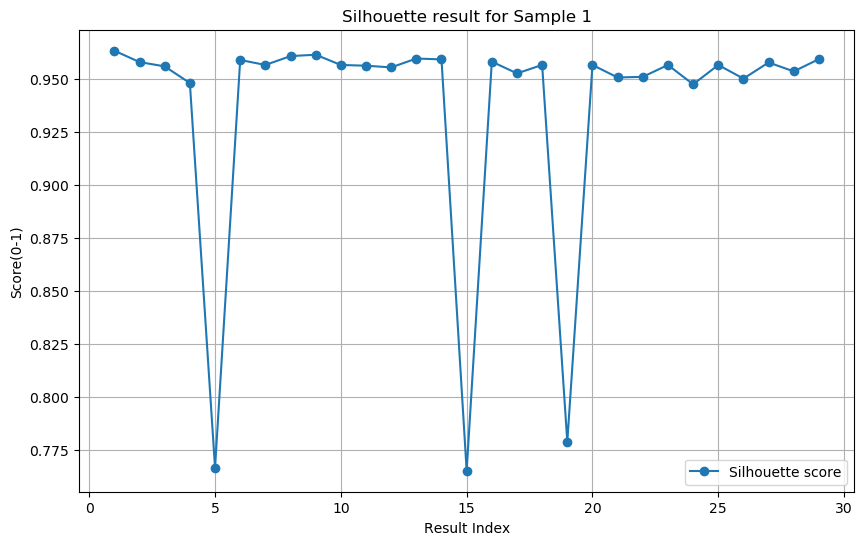

In [11]:
import matplotlib.pyplot as plt
# Plotting silhouette_results
for i, dist in enumerate(silhouette_results):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(dist) + 1), dist, marker='o', linestyle='-', label='Silhouette score')
    plt.title(f'Silhouette result for Sample {i+1}')
    plt.xlabel('Result Index')
    plt.ylabel('Score(0-1)')
    plt.legend()
    plt.grid(True)
    plt.savefig(Path(f'plots/{current_full_time}/sample_{i+1}_silhouette_result.png'))
    plt.show()

In [12]:

indexes = range(1, len(test_losses) + 1)

# Plotting the data
plt.figure(figsize=(8, 6))
plt.plot(indexes, test_losses, marker='o', linestyle='-', color='b', label='Losses')
plt.title('Test Losses Over Indexes')
plt.xlabel('Index')
plt.ylabel('Loss(0-1)')
plt.grid(True)
plt.xticks(indexes)  # Set x-ticks to match the indexes
plt.yscale('log')  # Log scale due to the wide range of values
plt.show()

NameError: name 'test_losses' is not defined

In [8]:
# Plotting distances
for i, dist in enumerate(distances):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(dist) + 1), dist, marker='o', label='Distance between points')
    plt.title(f'Distances for Sample {i+1}')
    plt.xlabel('Point Index')
    plt.ylabel('Distance(m)')
    plt.legend()
    plt.grid(True)
    plt.savefig(Path(f'plots/{current_full_time}/sample_{i+1}_distances.png'))
    plt.show()

NameError: name 'distances' is not defined

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model(f'{last_time}.h5')
